In [141]:
import numpy as np
from Bio import SeqIO
import random
import re
import progressbar
import matplotlib.pyplot as plt
from sklearn import metrics
from itertools import cycle
from optparse import OptionParser
from itertools import cycle



In [263]:
def read_file(file):
    seqs = []
    with open(file,'r') as f:
        for seq in f:
            seqs.append(seq.strip())
    return seqs

def read_files(posfile, negfile):
    pos_seqs = []
    with open(posfile,'r') as f:
        for seq in f:
            pos_seqs.append(seq.strip())
    #This removes the sequences from positive file
    neg_seqs = []
    true_neg = []
    for record in SeqIO.parse(negfile,"fasta"):
        neg_seqs.append(str(record.seq))
    for neg_seq in neg_seqs:
        if not any(pos_seq in neg_seq for pos_seq in pos_seqs):
            true_neg.append(neg_seq)
    #Here, I am taking every 17bp of neg seq as a unit. Ideally, I'd do
    #a permutation of all possible 17bp in the neg seq but it's
    #memory intensive so, I'm trying this first.
    X = []
    k = 0
    for i in true_neg:
        n = 0
        for j in i:
            X.append([])
            X[k].extend(i[n:n+17])
            n += 17
            k += 1
    cut_neg = [s for s in X if len(s) > 16]
    return pos_seqs, cut_neg

def dna_to_vec(sequences):
    Xt = []
    i = 0
    for base in sequences:
        Xt.append([])
        for ch in base:
            if ch == 'A':
                Xt[i].extend([0,0,0,1])
            elif ch == 'T':
                Xt[i].extend([0,0,1,0])
            elif ch == 'G':
                Xt[i].extend([0,1,0,0])
            elif ch == 'C':
                Xt[i].extend([1,0,0,0])
        i += 1
    X = np.array(Xt)
    return X
        

In [305]:
class neuralnet(object):
    
    def __init__(self,inputLayerSize,hiddenLayerSize,outputLayerSize):
        #Adjust the hyperparameter as needed
        self.inputLayerSize = inputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.outputLayerSize = outputLayerSize

        #For weights parameters
        #You need weigh matrix between input and hidden layer, and also between
        #hidden and output layer. For now, they are just random values now.
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        self.bias1 = np.random.randn(1,self.hiddenLayerSize)
        self.bias2 = np.random.randn(1,self.outputLayerSize)

    def forward(self,X):
    	#This is a feedforward function, where you estimate the output
    	#using the weigh matrix and activation function in each layer.
        
        self.z2 = np.dot(X,self.W1) + self.bias1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.bias2
        yHat = self.sigmoid(self.z3)
        return yHat

    def sigmoid(self, z):
    	#This is one type of activation function that we are using.
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
    	#This is derivative of sigmoid function. This is needed to calculate
    	#gradient descent.
        return np.exp(-z)/((1+np.exp(-z))**2)

    def costFunction(self, X, y, lam):
        '''
        J tells you what the difference is between the predicted and actual result.
        Compute cost for given X,y, use weights already stored in class.
        To avoid overfitting, we add a regularization paramter, lam to our cost function.
        The higher the lam value, the bigger the penalties impose.

        '''
        m = len(X[0])
        self.yHat = self.forward(X)

        J = (1/m) * np.sum((y - self.yHat)**2) + ((lam/2) * (np.sum(self.W2**2) + np.sum(self.W1**2)))
        
        return J

    def costFunctionPrime(self, X, y):
        #To get a batch gradient descent, we need to do more derivatives.
        self.yHat = self.forward(X)
        #We need to add lam to make sure we are not overfitting
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        dJdb1 = delta2
        dJdb2 = delta3

        return dJdW1, dJdW2, dJdb1, dJdb2

    def train(self,X,y,iterations,alpha,lam):
        self.X = X
        self.y = y
        m = X.shape[0]
        bar = progressbar.ProgressBar(maxval=iterations,widgets=[progressbar.Bar('=','[',']'),' ', progressbar.Percentage()])
        bar.start()
        count=0
        for i in range(0,iterations):
            count +=1
            bar.update(i+1)
            #Reset parameters at each iteration.
            #And do more PDE until you can't do anymore.
            dW1 = np.zeros((self.inputLayerSize,self.hiddenLayerSize))
            dW2 = np.zeros((self.hiddenLayerSize,self.outputLayerSize))
            db1 = np.zeros((1,self.hiddenLayerSize))
            db2 = np.zeros((1,self.outputLayerSize))
            dJdW1,dJdW2,dJdb1,dJdb2 = self.costFunctionPrime(X,y)
            dW1 += dJdW1
            dW2 += dJdW2
            for j in range(0,(m-1)):
                db1 += dJdb1[j]
                db2 += dJdb2[j]
            #Altering the parameters
            self.W1 = self.W1 - alpha*(((1/m)*dW1)+lam*self.W1)
            self.W2 = self.W2 - alpha*(((1/m)*dW2)+lam*self.W2)
            self.bias1 = self.bias1 - alpha*((1/m)*db1)
            self.bias2 = self.bias2 - alpha*((1/m)*db2)
        bar.finish()
        print('Score:')
        print(self.costFunction(X,y,lam))
        return self.forward(X)

    #The following functions test for a single example
    def forward_stochastic(self,X,k):
    	#This is a feedforward function, where you estimate the output
    	#using the weigh matrix and activation function in each layer.
        self.z2 = np.dot(X[k],self.W1) + self.bias1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2,self.W2) + self.bias2
        yHat = self.sigmoid(self.z3)
        return yHat
    
    def costFunction_stochastic(self,X,y,k,lam):
        m = len(X[0])
        self.yHat_s = self.forward_stochastic(X,k)
        J = np.sum((y[k] - self.yHat_s)**2) + ((lam/2) * (np.sum(self.W2**2) + np.sum(self.W1**2)))
        return J

    def costFunctionPrime_stochastic(self, X, y,k):
        #To get a batch gradient descent, we need to do more derivatives.
        self.yHat = self.forward_stochastic(X,k)
        #We need to add lam to make sure we are not overfitting
        delta3 = np.multiply(-(y[k]-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3,self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X[k].T.reshape(self.inputLayerSize,1),delta2)
        dJdb1 = delta2
        dJdb2 = delta3

        return dJdW1, dJdW2, dJdb1, dJdb2

    def train_stochastic(self,X,y,iterations,alpha,lam,pos_len,neg_len):
        self.X = X
        self.y = y
        m = X.shape[0]
        pos, neg = 0,0
        bar = progressbar.ProgressBar(maxval=iterations,widgets=[progressbar.Bar('=','[',']'),' ', progressbar.Percentage()])
        bar.start()
        for i in range(0,iterations):
            bar.update(i+1)
            #Generate a random number to see the index which dataset to use.
            #Get the index of pos_vec if it's > 0.3.
            #If less, use that of negative.
        rand = random.uniform(0,1) # This is the random number that determines whether positive or negative data will be used this iteration.
        if rand > 0.3:
            rand2 = random.randint(0,pos_len-1) # If it's greater than 0.3, use positive data.
        else:
            rand2 = random.randint(pos_len,neg_len) # If less, use negative.
        # Positive vs negative data is determined by the index of the numpy array. The way the data is set up, positive data comes before neagtive.

        new_costfunc = self.costFunction_stochastic(X,y,rand2,lam)
        new_alpha = (2*alpha * new_costfunc) + alpha #Use cost function value to alter alpha.
        # Set update matrices to zero each iteration
        dW1 = np.zeros((self.inputLayerSize,self.hiddenLayerSize))
        dW2 = np.zeros((self.hiddenLayerSize,self.outputLayerSize))
        db1 = np.zeros((1,self.hiddenLayerSize))
        db2 = np.zeros((1,self.outputLayerSize))

        # Find partial derivatives
        dJdW1,dJdW2,dJdb1,dJdb2 = self.costFunctionPrime_stochastic(X,y,rand2)
        # Update "change" matrices
        dW1 += dJdW1
        dW2 += dJdW2
        db1 += dJdb1
        db2 += dJdb2

        # And finally, update the weight and bias matrices. Since they are class objects, these will be stored outside of this function for use with test data.
        self.W1 = self.W1 - new_alpha*(((1/m) * dW1) + lam * self.W1)
        self.W2 = self.W2 - new_alpha*(((1/m) * dW2) + lam * self.W2)
        self.bias1 = self.bias1 - new_alpha*((1/m) * db1)
        self.bias2 = self.bias2 - new_alpha*((1/m) * db2)
        bar.finish()
        print('Score:')
        return self.forward(X)

In [306]:
#Reading in data
posfile='rap1-lieb-positives.txt'
negfile='yeast-upstream-1k-negative.fa'
pos_seqs, cut_neg = read_files(posfile, negfile)
pos_vec, neg_vec = dna_to_vec(pos_seqs),dna_to_vec(cut_neg)

In [307]:
#Creating datasets for cross-validation by shuffling positive datasets
avgC = int(round(pos_vec.shape[0]/5))
np.random.shuffle(pos_vec)
pos_a = pos_vec[:avgC]
pos_b = pos_vec[avgC:2*avgC]
pos_c = pos_vec[2*avgC:3*avgC]
pos_d = pos_vec[3*avgC:4*avgC]
pos_e = pos_vec[4*avgC:]
pos_list =[pos_a,pos_b,pos_c,pos_d,pos_e]
#Creating output datasets
y_a = np.ones((pos_a.shape[0],1))
y_b = np.ones((pos_b.shape[0],1))
y_c = np.ones((pos_c.shape[0],1))
y_d = np.ones((pos_d.shape[0],1))
y_e = np.ones((pos_e.shape[0],1))
y_list = [y_a,y_b,y_c,y_d,y_e]

#Repeat the same thing for negative datasets
avgK = int(round(neg_vec.shape[0]/5))
np.random.shuffle(neg_vec)
neg_a = neg_vec[:avgK]
neg_b = neg_vec[avgK:2*avgK]
neg_c = neg_vec[2*avgK:3*avgK]
neg_d = neg_vec[3*avgK:4*avgK]
neg_e = neg_vec[4*avgK:]
neg_list =[neg_a,neg_b,neg_c,neg_d,neg_e]
#Creating prediction output datasets
yhat_a = np.ones((neg_a.shape[0],1))
yhat_b = np.ones((neg_b.shape[0],1))
yhat_c = np.ones((neg_c.shape[0],1))
yhat_d = np.ones((neg_d.shape[0],1))
yhat_e = np.ones((neg_e.shape[0],1))
yhat_list = [yhat_a,yhat_b,yhat_c,yhat_d,yhat_e]

[========================================================================] 100%


Score:


/Users/Snow/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Snow/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


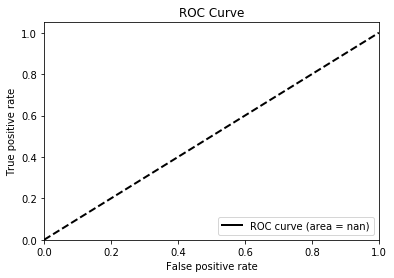

AAAAAAACGCAACTAAT	[0.00091519]	
AAAAACACACATCTGGC	[0.00020551]	
AAAACCAAACACCTGAA	[1.34106696e-07]	
AAAACCAAACAGCTCAG	[1.53964926e-06]	
AAAACCAAACATATCAA	[8.95345403e-08]	
AAAACCAAACATATCAA	[8.95345403e-08]	
AAAACCACACACATCGC	[0.05619202]	
AAAACCACACCTTGTAT	[6.57614091e-08]	
AAAACCAGACATACTAA	[2.11698162e-05]	
AAAACCAGACCCTTTAC	[2.34862521e-05]	
AAAACCAGGCACCAAGG	[0.08233483]	
AAAACCATACACATTCG	[0.00043248]	
AAAACCATAGACTTCTC	[0.00058427]	
AAAACCATCCATCCTGT	[0.04706943]	
AAAACCATGCAGTTCTT	[3.88226713e-05]	
AAAACCATGCCGTTGAA	[3.97946411e-09]	
AAAACCATTCCCAACAA	[1.35349017e-06]	
AAAACCTTACATTGTTC	[0.00029201]	
AAAAGCACGCATCCGGC	[0.02895155]	
AAAAGCACGCATCCGGC	[0.02895155]	
AAAAGCATACCCCGCAC	[0.00051306]	
AAAAGCATGCACCTTGC	[0.60221987]	
AAAATCATACATTTCCA	[3.54133635e-05]	
AAAATCATACATTTCGG	[0.00052363]	
AAACACACAAACGCCAG	[0.13739981]	
AAACACACAAACGCCAG	[0.13739981]	
AAACACACACACACAAA	[0.00164124]	
AAACACACACACTCACC	[0.08253382]	
AAACACAGATACCTCGA	[0.05240083]	
AAACACATACACCTTAA	[0.0007195

AAGCACATCCACCTCAT	[0.3214064]	
AAGCCCAAACCCTTGAC	[2.07474146e-07]	
AAGCCCAAACTCCCGCT	[0.00013405]	
AAGCCCAAGCCTCAAAC	[1.89580279e-06]	
AAGCCCAAGCCTCAAAC	[1.89580279e-06]	
AAGCCCAAGGATTTGGC	[4.77014949e-06]	
AAGCCCACACCTGCTCC	[0.00047615]	
AAGCCCACCCACTACAA	[3.41448955e-05]	
AAGCCCACTCCCGTCTC	[0.00177961]	
AAGCCCAGTCCTTTCAA	[6.89253712e-05]	
AAGCCCATAGGCTTCGT	[0.00067155]	
AAGCCCATCCACGTAAC	[0.00762099]	
AAGCCCATCCCCTGAAC	[1.08027908e-05]	
AAGCCCATGCTACTCAA	[4.2191456e-06]	
AAGCCCATTCCACCCAT	[0.0023202]	
AAGCCCGTGCACCGCAA	[0.27782987]	
AAGCCCTGGCCTCCCGG	[0.00063559]	
AAGCCCTTACATACTTT	[0.00295903]	
AAGCGCATATACTTAGT	[0.02997869]	
AAGCTCACACATACGAT	[0.00808497]	
AAGCTCATACAAACCAA	[0.05357597]	
AAGCTCATAGACCTTTT	[0.12371596]	
AAGCTCATCAACCCTAA	[0.76076491]	
AAGCTCGCTGACCTTTC	[0.99065695]	
AAGGCCAAACAACTCAT	[0.00051272]	
AAGGCCATGCACATAAT	[0.0351978]	
AAGGGCAGACACCACTG	[0.72196604]	
AAGGGCATACATCAAGA	[0.00123606]	
AAGGTCACACATCACAA	[0.01483166]	
AAGTACAAACATTTAAC	[4.20326258e-06]	
AAGTACAC

ACTCCAAGACATGGAGA	[7.57135353e-06]	
ACTCCAGTACCTAGCAC	[1.14844991e-08]	
ACTCCCAAACACACACA	[0.00022502]	
ACTCCCAGTCCCCCGAA	[2.95657785e-05]	
ACTCCCATAAATTCGAT	[6.24815858e-07]	
ACTCCCATATACACCAT	[0.00042941]	
ACTCCCGGGCATTATTT	[5.62633068e-05]	
ACTCCCTGTCACCGAAA	[0.00045044]	
ACTCCCTTACCCGACGG	[1.21149402e-06]	
ACTCGCAGACCCCCCAA	[0.00074378]	
ACTGATGCGTAACTTGT	[0.00173805]	
ACTGCCATACACAATGT	[0.00020829]	
ACTTACACGCACCTCTT	[0.00036262]	
ACTTCCAAACAACTGGT	[6.14510732e-07]	
ACTTCCAAATCCTTCAC	[1.79820434e-07]	
ACTTCCACAAACGTCAC	[0.00038226]	
ACTTCCACATACTTGGA	[2.45527916e-08]	
ACTTCCACGGATCCCAA	[1.04035808e-05]	
ACTTCCAGACATTTTAG	[1.0489378e-06]	
ACTTCCATACCCTGCTG	[1.44823445e-09]	
ACTTCCATAGACATTGA	[8.41656823e-06]	
ACTTCCATATACCTAAA	[3.04260901e-06]	
ACTTCCATGAATCTTGC	[0.00013765]	
ACTTCCCTGCACCTGTT	[3.05264874e-06]	
ACTTCCGGACATTTCCT	[0.00024969]	
ACTTCCTCACCTCTCCT	[9.49837527e-07]	
ACTTGCATACACGTAAC	[0.00046317]	
ACTTGTGCACTTCTTTT	[1.88637657e-06]	
AGAACCACACATTTTGC	[0.00117143]	
AGAAC

GCCCCCGCGAACGCCAT	[0.45103787]	
GCCCCCGCTCACCTGGG	[0.10705444]	
GCCCGCACGCATTTCCC	[0.02063112]	
GCCCTCACAGACTTCGT	[0.06283956]	
GCCCTCATCCGCTTCGT	[0.00666308]	
GCCGCCATCTCCTTCAA	[1.57776376e-07]	
GCCGCCATTCACCTCTC	[0.77599843]	
GCCTACATAAATCTTAA	[0.00011094]	
GCCTACATAAATCTTAA	[0.00011094]	
GCCTACATATATTTCGT	[7.33735392e-05]	
GCCTACGTACACTTCCA	[0.00778999]	
GCCTCAAAACACAACAA	[1.82422811e-05]	
GCCTCCAAACAATTACA	[1.63219195e-05]	
GCCTCCAAAGCCCTTCT	[0.00018185]	
GCCTCCAAATACTTACG	[0.00041409]	
GCCTCCACACATTAAAA	[4.69038421e-06]	
GCCTCCAGAGACTTGTA	[7.4390898e-06]	
GCCTCCATATACTGGTA	[5.02389448e-06]	
GCCTCCATATATCCTTA	[0.01586248]	
GCCTCCATATATCCTTA	[0.01586248]	
GCCTCCATGCGTCTCCT	[0.00512168]	
GCCTCCGTACCCTCACA	[0.00242118]	
GCCTCTACGCACCTAAA	[7.86444995e-05]	
GCCTCTGTACACCTCAC	[0.17613257]	
GCCTTAGCTCAAGTTCC	[0.90158617]	
GCCTTCAAACATCTTAG	[0.00139728]	
GCCTTCACAAACTACGA	[0.00412211]	
GCCTTCAGACATATCAG	[0.00265767]	
GCCTTCATAAGCTACGT	[0.0018944]	
GCCTTCATGCCTGCCTC	[1.37625621e-05]	
GCGACC

In [308]:
nn = neuralnet(68,200,1)
pos = np.concatenate(pos_list)
neg = np.concatenate(neg_list)
y = np.concatenate(y_list)
yhat = np.concatenate(yhat_list)
Xtrain = np.concatenate((pos,neg))
ytrain = np.concatenate((y,yhat))
y_hat = nn.train_stochastic(Xtrain,ytrain,100,10,0, pos.shape[0],neg.shape[0]) 

#Generating ROC curve.
fpr,tpr,thresholds = metrics.roc_curve(ytrain,y_hat)
roc_auc = metrics.auc(fpr,tpr)

plt.plot(fpr,tpr,color = 'black',lw = 2,label = 'ROC curve (area = {})'.format(roc_auc))
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.show()

Xtest = read_file("rap1-lieb-test.txt") # Testing dataset
Xtest_vec = dna_to_vec(Xtest)
yhat_test = nn.forward(Xtest_vec) # Run data through NN
# Save data to text file

with open("yhat_test_snow.txt", "w") as f:
    for i, seq in enumerate(Xtest):
        print (seq + "\t" + str(yhat_test[i]) + "\t")
        f.write(seq)
        f.write("\t")
        f.write(str(yhat_test[i]))
        f.write("\t")

In [313]:
len(y_hat)

179722

Training dataset 1


/Users/Snow/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Snow/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


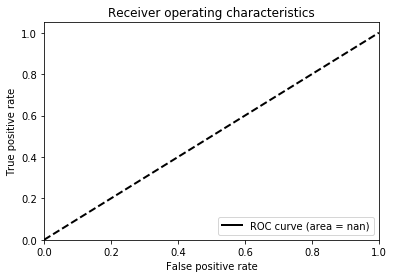

Training dataset 2


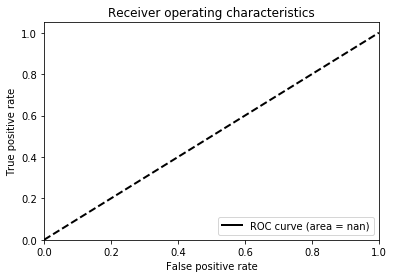

Training dataset 3


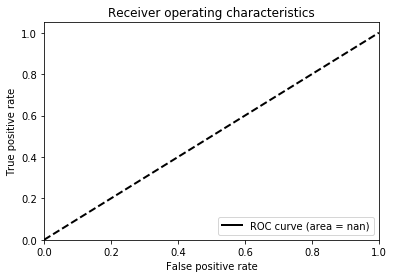

Training dataset 4


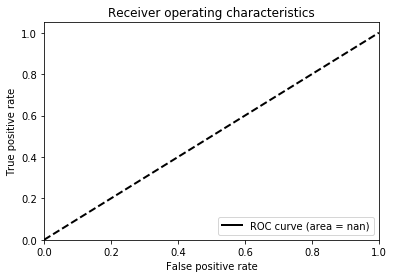

Training dataset 5


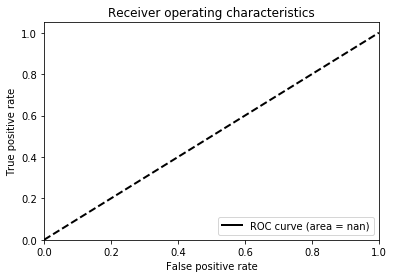

In [309]:
for i in range(0,5):
    print("Training dataset {}".format(i+1))
    nn.__init__(68,200,1) # Reinitialize the neural network class so that each withheld dataset gets a fresh neural net.
    # Choose withheld dataset based on i.
    pos_test = pos_list[i]
    neg_test = neg_list[i]
    y_test = y_list[i]
    yhat_test = yhat_list[i]
    Xtrainlistpos = []
    Xtrainlistneg = []
    ytrainlistpos = []
    ytrainlistneg = []
    for j in range(0,5):
        if j != i:
            # Choose training dataset (all j for j !=i)
            Xtrainlistpos.append(pos_list[j])
            Xtrainlistneg.append(neg_list[j])
            ytrainlistpos.append(y_list[j])
            ytrainlistneg.append(yhat_list[j])

    Xtrainpos = np.concatenate(Xtrainlistpos)
    Xtrainneg = np.concatenate(Xtrainlistneg)
    ytrainpos = np.concatenate(ytrainlistpos)
    ytrainneg = np.concatenate(ytrainlistneg)
    Xtrain = np.concatenate((Xtrainpos,Xtrainneg))
    ytrain = np.concatenate((ytrainpos,ytrainneg))

    Xtest = np.concatenate((pos_test,neg_test))
    ytest = np.concatenate((y_test,yhat_test))
    # Get scores from nn.forward for test dataset, then generate and ROC curve.
    scores = nn.forward(Xtest)
    fpr,tpr,thresholds = metrics.roc_curve(ytest,scores)
    roc_auc = metrics.auc(fpr,tpr)
    lw = 2
    colors = cycle(['aqua','darkorange','cornflowerblue','darkred','black'])

    plt.plot(fpr,tpr,color = 'black',lw = lw,label = 'ROC curve (area = {})'.format(roc_auc))
    plt.plot([0,1],[0,1],'k--',lw=lw)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristics')
    plt.legend(loc = "lower right")
    plt.show()
